In [ ]:
!git clone https://github.com/eriklindernoren/PyTorch-GAN/

In [2]:
%cd PyTorch-GAN/implementations/pix2pix

C:\Users\Moon\Colorization\PyTorch-GAN\implementations\pix2pix


In [3]:
!ls

Untitled.ipynb
__pycache__
datasets.py
models.py
pix2pix.py


In [18]:
import numpy as np 
import pandas as pd 
import os
import cv2
from tqdm.auto import tqdm

import glob
import random
import os
import numpy as np

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

class ImageDataset_color(Dataset):
    
    def __init__(self, original_root, cvd_root, transforms_=None, mode="train"):
        self.transform = transforms.Compose(transforms_)
        self.original_files = sorted(glob.glob(os.path.join(original_root, mode) + "/*.*"))  # Original 
        self.cvd_files = sorted(glob.glob(os.path.join(cvd_root, mode) + "/*.*"))  # CVD simulated 
        
    def __getitem__(self, index):
        '''img_A : RGB color image (1024, 1024, 3)
           img_B : CVD simulated image (1024, 1024, 3)'''
        img_A = cv2.imread(self.original_files[index % len(self.original_files)])
        img_A = cv2.cvtColor(img_A, cv2.COLOR_BGR2RGB)
        
        img_B = cv2.imread(self.cvd_files[index % len(self.cvd_files)])
        img_B = cv2.cvtColor(img_B, cv2.COLOR_BGR2RGB)
        
        img_A = Image.fromarray(np.array(img_A), "RGB")
        img_B = Image.fromarray(np.array(img_B), "RGB")
        if np.random.random() < 0.5:
            img_A = Image.fromarray(np.array(img_A)[:, ::-1, :], "RGB")
            img_B = Image.fromarray(np.array(img_B)[:, ::-1, :], "RGB")

        img_A = self.transform(img_A)
        img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

    def __len__(self):
        return len(self.original_files)

In [11]:
# Configure dataloaders
transforms_ = [
    transforms.Resize((opt.img_height, opt.img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

original_root = "E:/global-wheat-detection/"
cvd_root = "E:/global-wheat-detection/cvd"

dataloader = DataLoader(
    ImageDataset_color("E:/global-wheat-detection/", "E:/global-wheat-detection/cvd",
                       transforms_=transforms_),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=0,
)

val_dataloader = DataLoader(
    ImageDataset_color("E:/global-wheat-detection/", "E:/global-wheat-detection/cvd",
                       transforms_=transforms_, mode="test"),
    batch_size=10,
    shuffle=True,
    num_workers=0,
)

C:\Users\Moon\Anaconda3\envs\iml\lib\site-packages\torchvision\transforms\transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [4]:
import os
import numpy as np
import math
import itertools
import time
import datetime
import sys

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

# pix2pix
from models import *
from datasets import *

import torch.nn as nn
import torch.nn.functional as F
import torch

In [13]:
generator = GeneratorUNet().cuda()
discriminator = Discriminator().cuda()

generator.load_state_dict(torch.load("E:/Colorization/pix2pix/cvd/saved_models/test1/generator_130.pth"))
discriminator.load_state_dict(torch.load("E:/Colorization/pix2pix/cvd/saved_models/test1/discriminator_130.pth"))

<All keys matched successfully>

In [20]:
cuda = True

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
Tensor

torch.cuda.FloatTensor

In [21]:
def sample_images():
    """Saves a generated sample from the validation set"""
    imgs = next(iter(val_dataloader))
    
    real_A = Variable(imgs["B"].type(Tensor))  # CVD simulated image (1024, 1024, 3)
    real_B = Variable(imgs["A"].type(Tensor))  # Color image (1024, 1024, 3)
    
    fake_B = generator(real_A)  # Generated color image
    
    img_sample = torch.cat((real_A.data, fake_B.data, real_B.data), -2).cpu().numpy().astype(np.float32)
    img_sample -= img_sample.min()
    img_sample /= img_sample.max()
    img_sample = img_sample.transpose(0, 2, 3, 1)
    plt.figure(figsize=[10, 20])
    for row in range(3):
        plt.subplot(1, 3, row+1)
        plt.imshow(img_sample[row])
    plt.show()

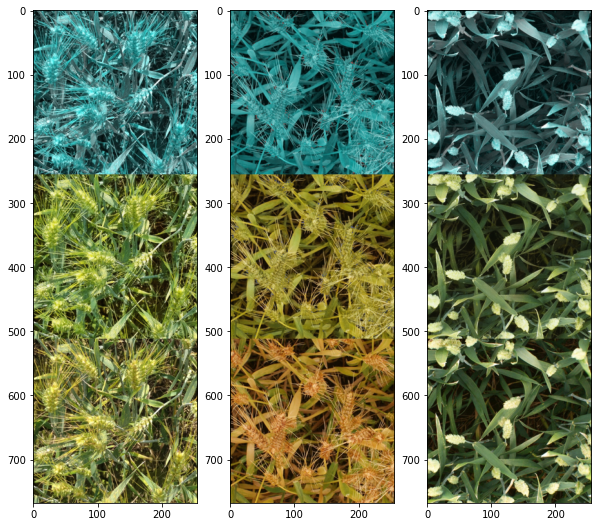

In [22]:
sample_images()